In [50]:
import numpy as np
import matplotlib.pyplot as plt


def initialize_particles_center_bias(n, radius, center_bias=0.7):
    """ Initialize particles with a bias towards the center. """
    angles = np.random.uniform(0, 2 * np.pi, n)
    radii = radius * np.sqrt(np.random.uniform(0, center_bias, n))  # Bias towards center of circle
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack((x, y))

def compute_forces_and_energy_vectorized(particles):
    """ Compute the forces and energy for the current configuration of particles using vectorized operations. """
    n = len(particles)
    diff = particles[:, np.newaxis, :] - particles[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    np.fill_diagonal(distances, np.inf)
    energy = np.sum(1 / distances[np.triu_indices(n, 1)])
    forces = np.sum(diff / distances[:,:,np.newaxis]**2, axis=1)
    return forces, energy

def update_particle_positions(particles, step_size, radius):
    """ Update the positions of particles randomly and handle infinitely hard wall boundary conditions. """
    n = len(particles)
    new_particles = np.copy(particles)

    for i in range(n):
        # Generate a random direction
        angle = np.random.uniform(0, 2 * np.pi)
        direction = np.array([np.cos(angle), np.sin(angle)])

        # Update the particle position in the random direction
        new_particles[i] += direction * step_size * np.random.uniform(0, 1)

        # Check if the particle is outside the boundary
        distance_from_center = np.linalg.norm(new_particles[i])
        if distance_from_center > radius:
            # If outside, reposition it on the boundary
            new_particles[i] = new_particles[i] / distance_from_center * radius

    return new_particles

def simulate_charged_particles_annealing(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp):
    """ Simulate the charged particles with simulated annealing, updating all particles at once. """
    particles = initialize_particles_center_bias(n, radius)
    min_energy_config = None
    min_energy = np.inf
    energies = []

    temperature = initial_temp
    step_size = initial_step_size

    # Calculate the cooling and step size rates
    cooling_rate = (final_temp / initial_temp) ** (1 / steps)
    step_rate = (final_step_size / initial_step_size) ** (1 / steps)

    for step in range(steps):

        forces, current_energy = compute_forces_and_energy_vectorized(particles)

        # Calculate new positions for all particles
        new_particles = update_particle_positions(particles, step_size, radius)
        new_energy = compute_forces_and_energy_vectorized(new_particles)[1]

        # Decide whether to accept the new configuration
        if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
            particles = new_particles
            current_energy = new_energy
        print(step, np.exp((current_energy - new_energy) / temperature), temperature)
        # Update energy, temperature, and step size after each step
        energy = compute_forces_and_energy_vectorized(particles)[1]
        energies.append(energy)

        if energy < min_energy:
            min_energy = energy
            min_energy_config = particles.copy()

       
        temperature = initial_temperature * (cooling_rate ** step)
        step_size *= step_rate

    return min_energy_config, min_energy, energies

0 1.0 500
1 1.0 500.0
2 1.0 499.8687935843617
3 1.0 499.7376215989704
4 1.0 499.6064840347912
5 1.0 499.47538088279146
6 1.0 499.3443121339411
7 1.0 499.21327777921215
8 1.0 499.08227780957924
9 1.0 498.95131221601923
10 1.0 498.8203809895115
11 1.0 498.68948412103754
12 1.0 498.5586216015815
13 1.0 498.4277934221297
14 1.0 498.2969995736708
15 1.0 498.1662400471961
16 1.0 498.03551483369887
17 1.0 497.90482392417505
18 1.0 497.77416730962284
19 1.0 497.64354498104274
20 1.0 497.51295692943773
21 1.0 497.3824031458131
22 1.0 497.2518836211765
23 1.0 497.12139834653783
24 1.0 496.99094731290955
25 1.0 496.8605305113063
26 1.0 496.7301479327453
27 1.0 496.59979956824577
28 1.0 496.46948540882966
29 1.0 496.33920544552115
30 1.0 496.2089596693466
31 1.0 496.0787480713349
32 1.0 495.9485706425174
33 1.0 495.81842737392753
34 1.0 495.6883182566012
35 1.0 495.5582432815768
36 1.0 495.4282024398948
37 1.0 495.2981957225983
38 1.0 495.1682231207325
39 1.0 495.0382846253452
40 1.0 494.908380227

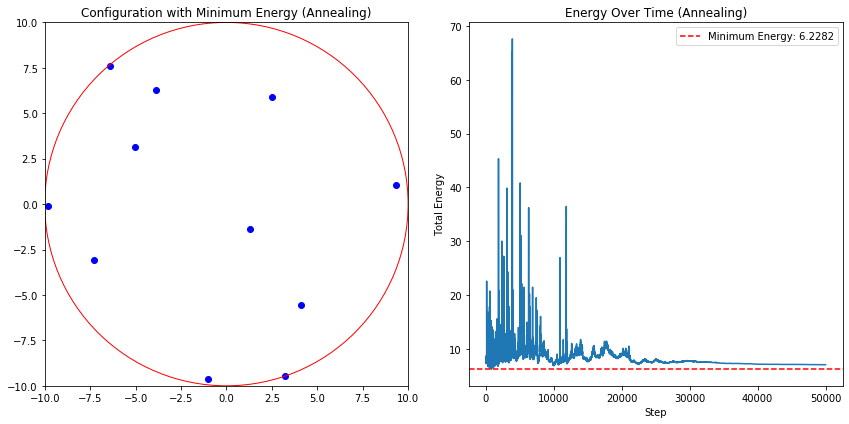

In [56]:

# Parameters
n_particles = 11  # Number of particles
circle_radius = 1  # Radius of the circle
simulation_steps = 50_000  # Number of steps in the simulation
initial_step_size = 0.5
final_step_size = 0.001
initial_temperature = 500  # Reduced initial temperature
final_temperature = 0.001  # Reduced final temperature


# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_charged_particles_annealing(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

# Plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()

0 1.0 500
1 1.0 500.0
2 1.0 499.8687935843617
3 1.0 499.7376215989704
4 1.0 499.6064840347912
5 1.0 499.47538088279146
6 1.0 499.3443121339411
7 1.0 499.21327777921215
8 1.0 499.08227780957924
9 1.0 498.95131221601923
10 1.0 498.8203809895115
11 1.0 498.68948412103754
12 1.0 498.5586216015815
13 1.0 498.4277934221297
14 1.0 498.2969995736708
15 0.9791160546541164 498.1662400471961
16 1.0 498.03551483369887
17 1.0 497.90482392417505
18 1.0 497.77416730962284
19 1.0 497.64354498104274
20 1.0 497.51295692943773
21 1.0 497.3824031458131
22 1.0 497.2518836211765
23 1.0 497.12139834653783
24 1.0 496.99094731290955
25 1.0 496.8605305113063
26 1.0 496.7301479327453
27 1.0 496.59979956824577
28 1.0 496.46948540882966
29 1.0 496.33920544552115
30 1.0 496.2089596693466
31 1.0 496.0787480713349
32 1.0 495.9485706425174
33 0.9939732297112333 495.81842737392753
34 1.0 495.6883182566012
35 1.0 495.5582432815768
36 1.0 495.4282024398948
37 1.0 495.2981957225983
38 1.0 495.1682231207325
39 1.0 495.0382

49 1.0 493.7407735599535
50 1.0 493.61120964564697
51 1.0 493.481679730574
52 1.0 493.35218380581273
53 1.0 493.22272186244373
54 1.0 493.0932938915499
55 1.0 492.9638998842163
56 1.0 492.83453983153055
57 1.0 492.7052137245825
58 1.0 492.5759215544643
59 1.0 492.4466633122705
60 1.0 492.317438989098
61 1.0 492.188248576046
62 1.0 492.0590920642161
63 1.0 491.9299694447121
64 1.0 491.80088070864036
65 1.0 491.6718258471093
66 1.0 491.5428048512298
67 1.0 491.4138177121152
68 1.0 491.28486442088087
69 1.0 491.15594496864486
70 1.0 491.02705934652727
71 1.0 490.8982075456508
72 1.0 490.76938955714013
73 1.0 490.6406053721225
74 1.0 490.51185498172754
75 1.0 490.3831383770871
76 1.0 490.25445554933526
77 1.0 490.1258064896086
78 1.0 489.99719118904596
79 1.0 489.8686096387884
80 1.0 489.7400618299796
81 1.0 489.6115477537652
82 1.0 489.48306740129345
83 1.0 489.3546207637147
84 1.0 489.2262078321818
85 1.0 489.09782859784985
86 1.0 488.96948305187624
87 1.0 488.84117118542076
88 1.0 488.7

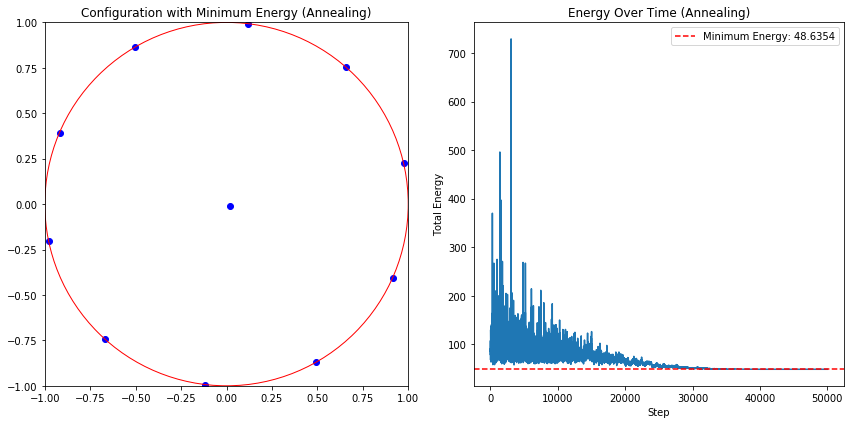

In [52]:
# Parameters
n_particles = 11  # Number of particles
circle_radius = 1  # Radius of the circle
simulation_steps = 50_000  # Number of steps in the simulation
initial_step_size = 0.3
final_step_size = 0.01
initial_temperature = 500  # Reduced initial temperature
final_temperature = 0.001  # Reduced final temperature


# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_charged_particles_annealing(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

# Plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()

In [53]:
def exponential_cooling(T0,t,a=0.9):
    return T0*a**t

def linear_cooling(T0,t,e):
    return T0-t*e

def logarithmic_cooling(T0,t,c,d):
    return c/np.log(t+d)


### Exponential cooling

In [54]:
def simulate_exp_annealing(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp):
    """ Simulate the charged particles with simulated annealing, updating all particles at once. """
    particles = initialize_particles_center_bias(n, radius)
    min_energy_config = None
    min_energy = np.inf
    energies = []

    temperature = initial_temp
    step_size = initial_step_size

    # Calculate the cooling and step size rates
    # cooling_rate = (final_temp / initial_temp) ** (1 / steps)
    step_rate = (final_step_size / initial_step_size) ** (1 / steps)

    for step in range(steps):

        forces, current_energy = compute_forces_and_energy_vectorized(particles, radius)

        # Calculate new positions for all particles
        new_particles = update_particle_positions(particles, step_size, radius)
        new_energy = compute_forces_and_energy_vectorized(new_particles, radius)[1]

        # Decide whether to accept the new configuration
        if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
            particles = new_particles
            current_energy = new_energy
        print(step, np.exp((current_energy - new_energy) / temperature), temperature)
        # Update energy, temperature, and step size after each step
        energy = compute_forces_and_energy_vectorized(particles, radius)[1]
        energies.append(energy)

        if energy < min_energy:
            min_energy = energy
            min_energy_config = particles.copy()

       
        temperature = exponential_cooling(initial_temperature,step,0.99)
        step_size *= step_rate

    return min_energy_config, min_energy, energies

In [55]:

# Parameters
n_particles = 11  # Number of particles
circle_radius = 1  # Radius of the circle
simulation_steps = 7500  # Number of steps in the simulation
initial_step_size = 0.3
final_step_size = 0.01
initial_temperature = 250  # Reduced initial temperature
final_temperature = 0.001  # Reduced final temperature


# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_exp_annealing(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()

TypeError: compute_forces_and_energy_vectorized() takes 1 positional argument but 2 were given